# 2.Linebot設計

```
當query包含"身高"、"體重"、"年齡"、"收入"等隱私時，回覆以下貼圖
```

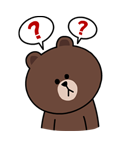

In [2]:
from IPython.display import Image 
Image(filename='play_dumb.PNG') 

In [3]:
from __future__ import unicode_literals
import os, requests, json, configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import *

app = Flask(__name__)

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('confing.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))

# 接收 LINE 資訊
@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)

    try:
        print("body:",body)
        print("signature:", signature)
        print("===")
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

# 回覆設定 (defaul僅能回固定語句)
@handler.add(MessageEvent, message=TextMessage)
def get_response(event):
    query = event.message.text 
    
    if any(i for i in ["身高", "體重", "年齡", "收入"] if i in query) :    
        line_bot_api.reply_message(event.reply_token,StickerSendMessage(package_id=2, sticker_id=149))
    
    else:
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="嗨嗨"))
if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Mar/2021 20:05:55] "POST /callback HTTP/1.1" 200 -


body: {"events":[],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: 6JTDQDe7+t05YXKoHthLUfA9y3iLiCG11hXSJF1FnUw=
===


127.0.0.1 - - [06/Mar/2021 20:06:08] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"9931570a510c4867836c95dfd0f20183","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032368154,"mode":"active","message":{"type":"text","id":"13670317188039","text":"嗚嗚"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: OlKGhyAVuSKmgrkOGfkTdbYulQN1b8Az5iCUGe84wD4=
===


127.0.0.1 - - [06/Mar/2021 20:06:13] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"a84ce69bdf76467790df3372f53d3c38","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032373525,"mode":"active","message":{"type":"text","id":"13670317650233","text":"身高"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: k29V1JsulTJT1DW5+8OT7EpGHU/SGjUWlH8Q9NO/1rk=
===


127.0.0.1 - - [06/Mar/2021 20:06:23] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"384d66c521294084953e1f8cd4c3742c","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032382777,"mode":"active","message":{"type":"sticker","id":"13670318440107","stickerId":"341693884","packageId":"12898178","stickerResourceType":"STATIC","keywords":["Beaming"]}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: 0jgPJucgYatoJQ9SEfLNH9gdB2wWd3/px0qDG9I7AqQ=
===
body: {"events":[{"type":"message","replyToken":"b7cdcaf1188e4e76993faf9b55f9ce35","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032397417,"mode":"active","message":{"type":"text","id":"13670319666499","text":"收入多少啦"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: CgYx08Bng3pPA/esWyj7wjLOBvQJonEV7GPJZBnwwXM=
===


127.0.0.1 - - [06/Mar/2021 20:06:37] "POST /callback HTTP/1.1" 200 -
127.0.0.1 - - [06/Mar/2021 20:06:42] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"3a800a3ceaba41ceb8410877c8bf00fc","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032401600,"mode":"active","message":{"type":"text","id":"13670320019657","text":"嗚嗚嗚"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: T1HULspkzXDUiYCbXWk6PIeJr95ZI5BwyI25sLifzEs=
===


## 3.以Python實現多輪對話

```
於多輪對話情境中加入"取得股價資訊的功能"，query為公司簡稱時(ex.鴻海)，即輸出2020/12/1 ~12/10之股價資訊
```

In [5]:
import pandas as pd
import datetime
def find_search_stock(stock_symbol):
    stock_symbol = str(stock_symbol)
    if len(stock_symbol) == 4 and stock_symbol.isdigit():
        search_str = stock_symbol
        
    else:

        stock_list = pd.read_csv('tw_stock_list.csv')
        stock_str2num = dict(zip(stock_list['STOCK_NAME'], stock_list['STOCK_SYMBOL']))
        search_str = stock_str2num.get(stock_symbol, '')
        
    if search_str != '':
        today = datetime.datetime.today()
        today_str = today.strftime('%Y-%m-%d')
        one_month_day = today - datetime.timedelta(30)
        one_month_str = one_month_day.strftime('%Y-%m-%d')
        
        stock_data = Stock.get_stockdata(search_str, one_month_str, today_str)
        stock_info = Stock.get_stockinfo(search_str, stock_data, "Close")
        
        return  f'stock: {search_str}\n' + stock_info
    return '你在公三小'

In [6]:
from __future__ import unicode_literals
import os, requests, json, configparser
from flask import Flask, request, abort
from linebot import LineBotApi, WebhookHandler
from linebot.exceptions import InvalidSignatureError
from linebot.models import *

import stock_utils as Stock
import thsr_utils as Thsr
thsr = Thsr.ThsrModule()

chat_record = []
thsr_res = {"starting":"", "ending":"", "date":"", "ampm":""}
station_names = Thsr.station_name
date_keys = Thsr.date_key
ampm_keys = Thsr.ampm_key


app = Flask(__name__)

# LINE 聊天機器人的基本資料
config = configparser.ConfigParser()
config.read('confing.ini')

line_bot_api = LineBotApi(config.get('line-bot', 'channel_access_token'))
handler = WebhookHandler(config.get('line-bot', 'channel_secret'))

# 接收 LINE 資訊
@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    app.logger.info("Request body: " + body)

    try:
        print("body:",body)
        print("signature:", signature)
        print("===")
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'

# 回覆設定 (加入高鐵API多輪對話)
@handler.add(MessageEvent, message=TextMessage)
def get_response(event):
    query = event.message.text       
    
    if len(chat_record) < 5:
        chat_record.append(query)
    else:
        chat_record.pop(0)
        chat_record.append(query)
    print("chat_record:",chat_record)


    # 判斷是否為"高鐵查詢意圖"
    if query == "高鐵":
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="哪一天出發?"))
#         chat_record = ["高鐵"]
    try:
        if chat_record[-2] == "高鐵" and any(chat_record[-1] == i for i in date_keys):
            date_format = thsr.get_date_string_today(chat_record[-1])
            thsr_res['date'] = date_format
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="上午還是下午的車?"))

        elif any(chat_record[-2] == i for i in date_keys) and any(chat_record[-1] == i for i in ampm_keys):
            thsr_res['ampm'] = chat_record[-1]
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="起站是哪裡呢?"))

        elif any(chat_record[-2] == i for i in ampm_keys) and any(chat_record[-1] == i for i in station_names):
            startind_id = Thsr.station_id[chat_record[-1]]
            thsr_res['starting'] = startind_id
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text="終點站是哪裡呢?"))

        elif any(chat_record[-2] == i for i in station_names) and any(chat_record[-1] == i for i in station_names):
            ending_id = Thsr.station_id[chat_record[-1]]
            thsr_res['ending'] = ending_id

            # print("***",thsr_res['starting'],thsr_res['ending'],thsr_res['date'],thsr_res['ampm'])
            text = thsr.get_runs(thsr_res['starting'],thsr_res['ending'],thsr_res['date'],thsr_res['ampm'])
            line_bot_api.reply_message(event.reply_token, TextSendMessage(text=text))

    except IndexError:
        pass
    
    if query == "股票":
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text="要找哪支股票?"))
#         chat_record = ["股票"]
    if "股票" in chat_record:
        result = find_search_stock(chat_record[-1])
        line_bot_api.reply_message(event.reply_token, TextSendMessage(text=result))
#     except:
#         line_bot_api.reply_message(event.reply_token, TextSendMessage(text="出錯惹嗚嗚嗚"))
         
    line_bot_api.reply_message(event.reply_token, TextSendMessage(text="嗚嗚嗚 輸入 高鐵 或 股票"))

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Mar/2021 20:10:18] "POST /callback HTTP/1.1" 200 -


body: {"events":[{"type":"message","replyToken":"45503909343845c9bc78b91e25eb2757","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032618516,"mode":"active","message":{"type":"text","id":"13670337804150","text":"嗨"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: 7BqywwPVxK/71A911/Jy5Z2DME8ECY3oEPtvAzrn8Bs=
===
chat_record: ['嗨']
body: {"events":[{"type":"message","replyToken":"4f7d7a929b4a4b46a6a1c32d1d770c83","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032623945,"mode":"active","message":{"type":"text","id":"13670338236402","text":"股票"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: bFzp/iu3EQrPIHal2hh0P9wr2m9vfoxVvIW3KPy2q58=
===
chat_record: ['嗨', '股票']


[2021-03-06 20:10:24,816] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-6-cc

body: {"events":[{"type":"message","replyToken":"7a9aee3a4b994d808e44bacfdba42187","source":{"userId":"U72d1ce6e444eedff9046de635661aabc","type":"user"},"timestamp":1615032628355,"mode":"active","message":{"type":"text","id":"13670338597045","text":"鴻海"}}],"destination":"Ub08d189067bd2fdeb7a14779756f8f08"}
signature: Ie8Q9V80PijS1Aj1iQFHMKYbROcGBZtu2+F8PkG5Srk=
===
chat_record: ['嗨', '股票', '鴻海']
[*********************100%***********************]  1 of 1 completed


[2021-03-06 20:10:28,996] ERROR in app: Exception on /callback [POST]
Traceback (most recent call last):
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-6-cc